# VRS file

In [ ]:
import os

ego_exo_root = os.path.join('/data2', 'EgoExo4D') # Replace with your cli's download directory for Ego-Exo4D
take_name = 'cmu_bike01_5'

ego_exo_project_path = os.path.join(ego_exo_root, 'takes', take_name)
print(f'EgoExo Sequence: {ego_exo_project_path}')

if not os.path.exists(ego_exo_project_path):
    print("Please do update your path to a valid EgoExo sequence folder.")

In [ ]:
from projectaria_tools.core import data_provider

vrs_file_path = os.path.join(ego_exo_project_path, 'aria01_noimagestreams.vrs')
print(vrs_file_path)
assert os.path.exists(vrs_file_path), "We are not finding the required vrs file"

vrs_data_provider = data_provider.create_vrs_data_provider(vrs_file_path)
if not vrs_data_provider:
    print("Couldn't create data vrs_data_provider from vrs file")
    exit(1)

In [ ]:
from projectaria_tools.core.stream_id import StreamId
from projectaria_tools.core.sensor_data import TimeDomain, TimeQueryOptions
from tqdm import tqdm
import numpy as np

###
# We are demonstrating here how to retrieve the time stamp of a given stream
# - and how to retrieve 10 frames along this time span
###

# rgb_stream_id = StreamId("214-1")
slam_left_stream_id = StreamId("1201-1")
slam_right_stream_id = StreamId("1201-2")
# rgb_stream_label = vrs_data_provider.get_label_from_stream_id(rgb_stream_id)
slam_left_stream_label = vrs_data_provider.get_label_from_stream_id(slam_left_stream_id)
slam_right_stream_label = vrs_data_provider.get_label_from_stream_id(slam_right_stream_id)

# Init rerun api
# rr.init("Aria Data Provider - Retrieve Image Stream data")
# rec = rr.memory_recording()

# Configure option for data retrieval
time_domain = TimeDomain.DEVICE_TIME  # query data based on host time
option = TimeQueryOptions.CLOSEST # get data whose time [in TimeDomain] is CLOSEST to query time
# vrs_data_provider.get_imu_data_by_time_ns()
# Retrieve Start and End time for the given Sensor Stream Id
start_time = vrs_data_provider.get_first_time_ns(slam_left_stream_id, time_domain)
end_time = vrs_data_provider.get_last_time_ns(slam_left_stream_id, time_domain)

# FYI, you can retrieve the Image configuration using the following
image_config = vrs_data_provider.get_image_configuration(slam_left_stream_id)
width = image_config.image_width
height = image_config.image_height
print(f"StreamId {slam_left_stream_id}, StreamLabel {slam_left_stream_label}, ImageSize: {width, height}")

sample_count = 10
sample_timestamps = np.linspace(start_time, end_time, sample_count)

In [ ]:
stream_id = vrs_data_provider.get_stream_id_from_label("imu-left")

accl = []
gyro = []
ts_ns = []

for index in range(0, int(vrs_data_provider.get_num_data(stream_id) / 10)):

    imu_data = vrs_data_provider.get_imu_data_by_index(stream_id, index)
    timestamp = imu_data.capture_timestamp_ns
    ts_ns.append(timestamp)
    accl.append(imu_data.accel_msec2),
    gyro.append(imu_data.gyro_radsec)

In [ ]:
len(accl), len(gyro), len(ts_ns)

In [ ]:
vrs_data_provider.get_num_data(stream_id)

In [ ]:
start_time = vrs_data_provider.get_first_time_ns(stream_id, time_domain)
end_time = vrs_data_provider.get_last_time_ns(stream_id, time_domain)

In [ ]:
(start_time / 1e9, end_time / 1e9)

# Takes metadata

In [ ]:
import json
import os

# Load the json file
# takes = pd.read_json(os.path.join(ego_exo_root, 'takes.json'))
ego_exo_root = os.path.join('/data2', 'EgoExo4D') # Replace with your cli's download directory for Ego-Exo4D
data_dir = os.path.join('/data2', 'EgoExo4D')
takes = json.load(open(os.path.join(ego_exo_root, 'takes.json')))

In [ ]:
takes[0]

In [ ]:
from projectaria_tools.core.stream_id import StreamId
from projectaria_tools.core.sensor_data import TimeDomain, TimeQueryOptions
from tqdm import tqdm
import numpy as np


def get_take_vrs_file(take_root_dir: os.PathLike):
    '''
    Get both IMU streams from the VRS file
    '''
    from projectaria_tools.core import data_provider

    # Get the VRS file
    vrs_file_path = os.path.join(take_root_dir, 'aria01_noimagestreams.vrs')
    assert os.path.exists(vrs_file_path), "We are not finding the required vrs file"

    # Create the VRS data provider
    vrs_data_provider = data_provider.create_vrs_data_provider(vrs_file_path)
    if not vrs_data_provider:
        # print("Couldn't create data vrs_data_provider from vrs file")
        exit(1)
    
    return vrs_data_provider

def get_imu_data(vrs_data_provider, stream_labels: list[str]):
    '''
    Get both IMU streams from the VRS file.

    Args:
    - vrs_data_provider: the VRS data provider
    - stream_labels: the labels of the streams to retrieve. ['imu-left', 'imu-right']

    '''
    stream_id = vrs_data_provider.get_stream_id_from_label(stream_labels[0])
    assert stream_id, f"Couldn't find stream id for {stream_labels[0]}"

    '''
    For each stream, we will get the IMU data for a total of 7 columns:
    - timestamps (in ns)
    - accelerometer data (in m/s^2) (x, y, z)
    - gyroscope data (in rad/sec) (x, y, z)
    '''
    left = np.zeros((vrs_data_provider.get_num_data(stream_id), 7))
    right = np.zeros((vrs_data_provider.get_num_data(stream_id), 7))

    for idx, stream_label in enumerate(stream_labels):
        stream_id = vrs_data_provider.get_stream_id_from_label(stream_label)

        for index in range(int(vrs_data_provider.get_num_data(stream_id))):
            imu_data = vrs_data_provider.get_imu_data_by_index(stream_id, index)
            timestamp = imu_data.capture_timestamp_ns
            try:
                if stream_label.endswith('left'):
                    left[index, 0] = timestamp
                    left[index, 1:4] = imu_data.accel_msec2
                    left[index, 4:] = imu_data.gyro_radsec
                else:
                    right[index, 0] = timestamp
                    right[index, 1:4] = imu_data.accel_msec2
                    right[index, 4:] = imu_data.gyro_radsec
            except:
                "skipping"

    return left, right

In [ ]:
from tqdm.auto import tqdm

missing_files = []
imu_path = os.path.join(data_dir, 'features', 'imu_aria01')
print("start")
for idx, take in enumerate(tqdm(takes, total=len(takes))):
    take_vrs_path = os.path.join(data_dir ,take['root_dir'])
    try:
        data_provider = get_take_vrs_file(take_vrs_path)
        # left, right = get_imu_data(data_provider,['imu-left', 'imu-right'])
        _, right = get_imu_data(data_provider,['imu-right'])
        take_name = take['take_name']
        path_take = os.path.join(imu_path, f"{take_name}")
        if not os.path.exists(path_take):
            os.makedirs(path_take)
        # np.save(os.path.join(path_take, 'left.npy'), left)
        np.save(os.path.join(path_take, 'right.npy'), right)

    except:
        missing_files.append(take_vrs_path)
        continue

In [ ]:
left.shape, right.shape

In [ ]:
prova_left, prova_right = left[0,0] / 1e9, right[0,0] / 1e9
prova_left, prova_right = prova_left.round(4), prova_right.round(4)
prova_left, prova_right

In [ ]:
right = right.T

In [ ]:
(right[0,-1] - right[0,0]) / 1e9

In [ ]:
missing_files

In [ ]:
print('Missing takes: ', len(missing_files))
missing_files_path = os.path.join('../data', 'EgoExo4D', 'missing_files.npy')
os.makedirs(os.path.dirname(missing_files_path), exist_ok=True)
np.save(missing_files_path, missing_files)

# Create Pretraining metadata with omnivore

In [1]:
import json
import os
import numpy as np
import pickle as pkl
import torch
from tqdm.auto import tqdm
import gc
import pandas as pd

# Load the json file
# takes = pd.read_json(os.path.join(ego_exo_root, 'takes.json'))
ego_exo_root = os.path.join('/data2', 'EgoExo4D') # Replace with your cli's download directory for Ego-Exo4D
data_dir = os.path.join('/data2', 'EgoExo4D')
takes = json.load(open(os.path.join(ego_exo_root, 'takes.json')))
# missing_files = np.load(os.path.join('../data', 'EgoExo4D', 'missing_files.npy'))
missing_files = pkl.load(open(os.path.join('../data', 'EgoExo4D', 'missing_files.pkl'), 'rb'))

In [2]:
takes[0]

{'root_dir': 'takes/cmu_bike01_2',
 'take_name': 'cmu_bike01_2',
 'participant_uid': 657,
 'is_dropped': False,
 'objects': [],
 'task_id': 4001,
 'task_name': 'Remove a Wheel',
 'parent_task_id': 4000,
 'parent_task_name': 'Bike Repair',
 'take_idx': 2,
 'duration_sec': 110.93333333333334,
 'best_exo': 'cam04',
 'task_start_sec': 0.28164,
 'task_end_sec': 110.06668,
 'task_timing_annotation_uid': '543a6b43-73ee-41d0-a45e-dbb8ce12434d',
 'is_narrated': False,
 'capture_uid': 'd37b73eb-fa42-43a6-8115-56832996ebd7',
 'take_uid': 'ed3ec638-8363-4e1d-9851-c7936cbfad8c',
 'take_timing_uid': '7811bafb-e625-4bd4-ab50-bf61c18e57c1',
 'timesync_uid': 'f66bd964-1bc1-4da5-a55f-4d5fc770db60',
 'timesync_start_idx': 7170,
 'timesync_end_idx': 10498,
 'frame_aligned_videos': {'aria01': {'slam-left': {'cam_id': 'aria01',
    'stream_id': '1201-1',
    'readable_stream_id': 'slam-left',
    'clip_uid': 'c8b91224-f392-489c-b007-eba0a090df01',
    'is_collage': False,
    'relative_path': 'frame_aligned

In [14]:
df = pd.read_json(os.path.join(ego_exo_root, 'takes.json'))
df = df[['task_id', 'task_name', 'parent_task_id', 'parent_task_name', 'duration_sec']]

In [15]:
df['duration_min'] = df['duration_sec'] / 60
df = df.sort_values(by=['duration_min'], ascending=True)

In [11]:
tasks = df['task_name']
tasks.drop_duplicates(inplace=True)
len(tasks)

85

In [7]:
df.head()

,task_id,task_name,parent_task_id,parent_task_name,duration_sec,duration_min
1607,6001,Basketball Drills - Mikan Layup,6000,Basketball,3.066667,0.051111
28,4002,Install a Wheel,4000,Bike Repair,3.533333,0.058889
3112,7019,LosAndes_V1_R1,7000,Rock Climbing,3.533333,0.058889
1781,6001,Basketball Drills - Mikan Layup,6000,Basketball,3.566667,0.059444
6,4004,Clean and Lubricate the Chain,4000,Bike Repair,3.666667,0.061111


<Axes: xlabel='parent_task_name'>

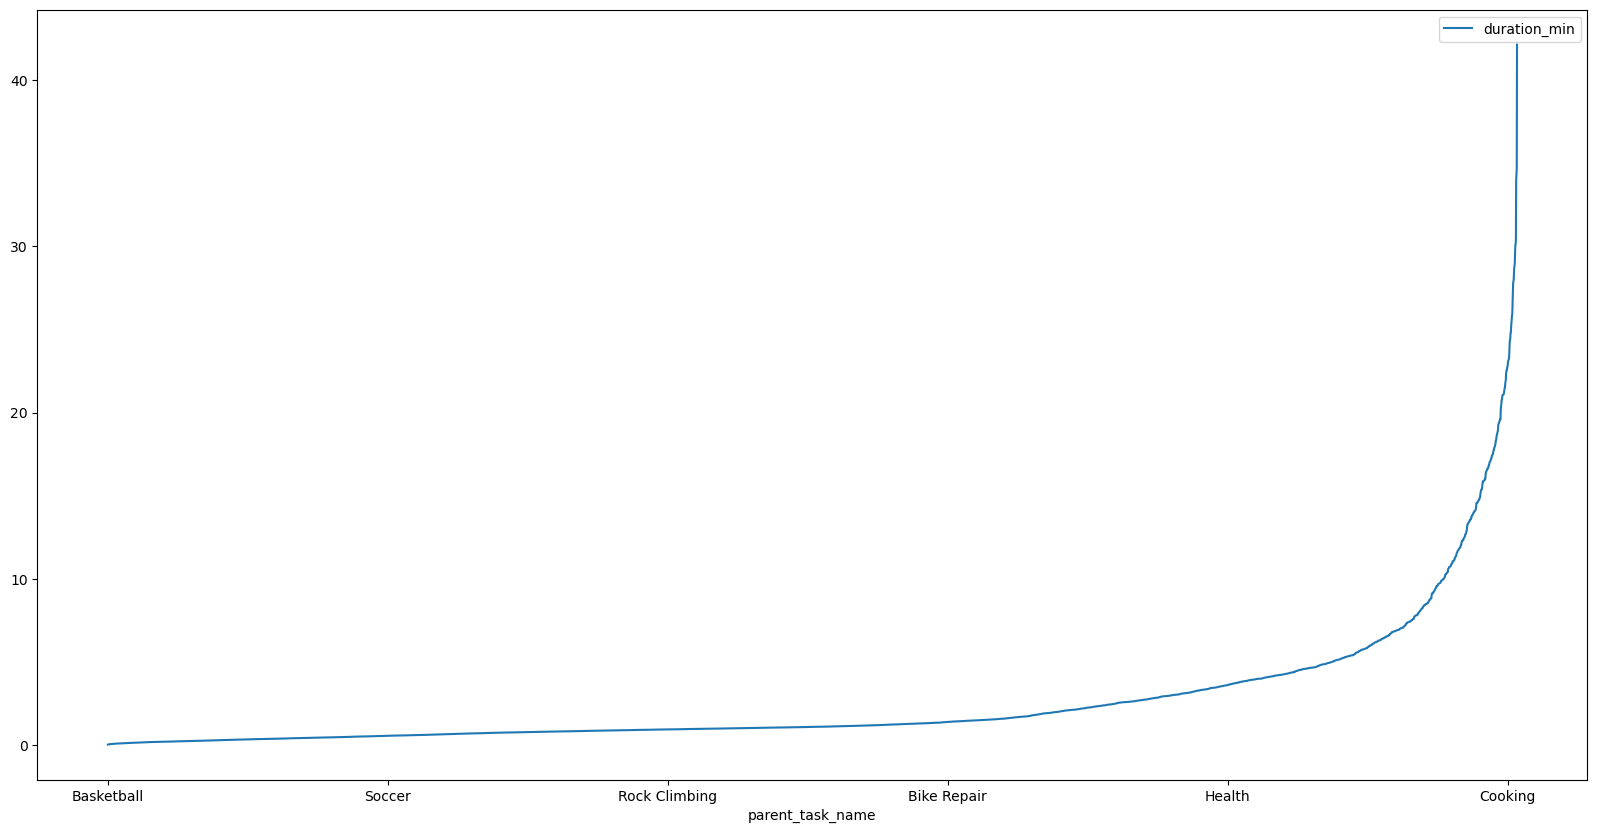

In [12]:
df.plot(kind='line', x='parent_task_name', y='duration_min', figsize=(20,10))

In [16]:
df.plot(kind='line', y='task_id', figsize=(20,10))

AttributeError: 'NoneType' object has no attribute 'plot'

In [37]:
annotations_pretrain = []
frame_skip = []

features_path = os.path.join(data_dir, 'features')
takes.reverse()
for idx, take in enumerate(tqdm(takes, total=len(takes))):
    if take['root_dir'].split('/')[1] in missing_files:
        print(f"Skipping {take['root_dir']}: missing file.")
        continue
    
    if take['task_timing_annotation_uid'] is None:
        print(f"Skipping {take['root_dir']}: missing task timing annotation.")
        continue

    take_imu_path = os.path.join(features_path,'imu_aria01', take['take_name'])
    start_sec = take['task_start_sec']
    end_sec = take['task_end_sec']
    take_duration = take['duration_sec']
    effective_duration = end_sec - start_sec
    
    omnivore_file = torch.load(os.path.join(features_path, 'omnivore_video', f"{take['take_uid']}_aria01_rgb.pt"))
    num_frames = omnivore_file.shape[0]

    # print(f"Take: {take['take_name']}, Duration: {take_duration}, NumFrames: {num_frames}")
    imu_left = torch.from_numpy(np.load(os.path.join(take_imu_path, 'left.npy'))).type(torch.float32).T
    imu_left = imu_left[0, :]
    imu_right = torch.from_numpy(np.load(os.path.join(take_imu_path, 'right.npy'))).type(torch.float32).T
    imu_right = imu_right[0, :]

    effective_start = imu_left[0] if imu_left[0] > imu_right[0] else imu_right[0]

    # print(f"Start: {start_sec}, End: {end_sec}, Subtract: {end_sec - start_sec}")
    for frame in range(0, num_frames):
        start_s = 16/30 * frame + start_sec
        end_s = start_s + 32/30

        if frame == len(omnivore_file) - 1 and end_s > end_sec:
            start_s = end_sec - 32/30
            end_s = end_sec

        start_ns = start_s * 1e9 + effective_start
        end_ns = end_s * 1e9 + effective_start

        left = imu_left[(imu_left >= start_ns) & (imu_left < end_ns)]
        right = imu_right[(imu_right >= start_ns) & (imu_right < end_ns)]

        if left.shape[-1] == 0 or right.shape[-1] == 0:
            print(f"Skipping frame {frame} for take {take['take_name']}: {effective_start=}")
            frame_skip.append({
                'take_name': take['take_name'],
                'take_uid': take['take_uid'],
                'omnivore_idx': frame
            })
            break
        del left
        del right

        annotations_pretrain.append({
            'take_name': take['take_name'],
            'take_uid': take['take_uid'],
            'start_sec': start_s,
            'end_sec': end_s,
            'omnivore_idx': frame
        })
        if frame % 80 == 0:
            gc.collect()
            
    del imu_left
    del imu_right
    gc.collect()

pkl.dump(annotations_pretrain, open(os.path.join('../data', 'EgoExo4D', 'annotations_pretrain.pkl'), 'wb'))
print(f'total annotations_pretrain = {len(annotations_pretrain)}')

  0%|          | 0/5035 [00:00<?, ?it/s]

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fe3a1f371d0>>
Traceback (most recent call last):
  File "/home/gatanasio/miniconda3/envs/audio-mae/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [5]:
frame_skip

[{'take_name': 'utokyo_sushi_9_1008_4',
  'take_uid': 'f1153847-d0ce-4c4d-86f3-e24e77bf80c8',
  'omnivore_idx': 964},
 {'take_name': 'utokyo_sushi_9_1008_2',
  'take_uid': 'a58a8078-a21f-47ab-bc47-0709d406709e',
  'omnivore_idx': 1214},
 {'take_name': 'utokyo_sushi_8_1008_4',
  'take_uid': 'c6717667-6605-4748-8a8e-81784fe0e18f',
  'omnivore_idx': 1440},
 {'take_name': 'utokyo_sushi_8_1008_2',
  'take_uid': '48de3f4e-c3b7-4990-9d57-517e96b65912',
  'omnivore_idx': 1453},
 {'take_name': 'utokyo_sushi_6_1008_4',
  'take_uid': 'fc938d8b-70ae-4ae9-82e7-b02e8f76e16c',
  'omnivore_idx': 1019},
 {'take_name': 'utokyo_sushi_6_1008_2',
  'take_uid': '919b1c28-68b1-4f17-81a5-85fbda8eecd7',
  'omnivore_idx': 1235},
 {'take_name': 'utokyo_sushi_4_1008_4',
  'take_uid': 'f05356c1-4fff-4024-a2e0-231910848516',
  'omnivore_idx': 845},
 {'take_name': 'utokyo_sushi_4_1008_2',
  'take_uid': '2ef294b5-5d85-49f6-8816-ca4bd653957d',
  'omnivore_idx': 1145},
 {'take_name': 'utokyo_sushi_1_1008_4',
  'take_ui

In [13]:
train_idx = int(len(annotations_pretrain) * 0.6)
valid_idx = test_idx = int(len(annotations_pretrain) * 0.2)

In [11]:
import random
random.shuffle(annotations_pretrain)

In [14]:
train = annotations_pretrain[ :train_idx ]
valid = annotations_pretrain[ train_idx : train_idx+valid_idx ]
test = annotations_pretrain[ train_idx + valid_idx: ]
pkl.dump(train, open(os.path.join('../data', 'EgoExo4D', 'annotations_train.pkl'), 'wb'))
pkl.dump(valid, open(os.path.join('../data', 'EgoExo4D', 'annotations_val.pkl'), 'wb'))
pkl.dump(test, open(os.path.join('../data', 'EgoExo4D', 'annotations_test.pkl'), 'wb'))

In [ ]:
n = 0
start, end = 16 / 30 * n, 16 / 30 * n + 32/30
start, end, end - start

# Investigate Keystep

In [1]:
import json
import os
import numpy as np
import pickle as pkl
import torch
from tqdm.auto import tqdm
import gc
import pandas as pd

# Load the json file
# takes = pd.read_json(os.path.join(ego_exo_root, 'takes.json'))
ego_exo_root = os.path.join('/data2', 'EgoExo4D') # Replace with your cli's download directory for Ego-Exo4D
data_dir = os.path.join('/data2', 'EgoExo4D')
takes = json.load(open(os.path.join(ego_exo_root, 'takes.json')))
keystep = json.load(open(os.path.join(ego_exo_root, 'annotations', 'keystep_train.json')))
# missing_files = np.load(os.path.join('../data', 'EgoExo4D', 'missing_files.npy'))
missing_files = pkl.load(open(os.path.join('../data', 'EgoExo4D', 'missing_files.pkl'), 'rb'))

In [21]:
keystep.keys()

dict_keys(['taxonomy', 'vocabulary', 'ds', 'annotations'])

In [3]:
len(keystep['vocabulary'])

665

In [6]:
keystep['vocabulary']

{'3': 'Wash hands',
 '4': 'Wipe hands',
 '7': 'Add almonds',
 '8': 'Add beef',
 '9': 'Add bell peppers',
 '10': 'Add black pepper',
 '12': 'Add cabbage',
 '14': 'Add carrots',
 '15': 'Add celeries',
 '16': 'Add cheese',
 '18': 'Add cherry tomatoes',
 '19': 'Add chili powder',
 '20': 'Add chocolate',
 '21': 'Add cilantro',
 '22': 'Add cinnamon powder',
 '25': 'Add coffee beans',
 '26': 'Add coffee grounds',
 '28': 'Add cucumber',
 '29': 'Add curry powder',
 '31': 'Add dried herbs',
 '33': 'Add eggs',
 '34': 'Add feta cheese',
 '40': 'Add fresh thyme',
 '41': 'Add garlic cloves',
 '42': 'Add garlic paste',
 '43': 'Add garlic powder',
 '44': 'Add fresh ginger',
 '46': 'Add ginger paste',
 '47': 'Add green chilies',
 '49': 'Add honey',
 '50': 'Add hot sauce',
 '52': 'Add ketchup',
 '54': 'Add lemon juice',
 '55': 'Add lettuce',
 '58': 'Add mayonnaise',
 '59': 'Add milk',
 '60': 'Add mustard',
 '62': 'Add noodles',
 '63': 'Add nutmeg',
 '64': 'Add oil',
 '67': 'Add onions',
 '70': 'Add pars

In [28]:
count = 0
for _, segments in keystep['annotations'].items():
    count += len(segments)
count

3340

### Create sub-task: verbs-only
From `keystep['vocabulary']`, it will be created a mapping between it and a vocaulary of unique verbs.

In [25]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/gatanasio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/gatanasio/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/gatanasio/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/gatanasio/nltk_data...


True

In [32]:
nltk.pos_tag(word_tokenize("to Add ginger garlic paste to a mixing bowl".lower()), tagset='universal')

[('to', 'PRT'),
 ('add', 'VERB'),
 ('ginger', 'ADJ'),
 ('garlic', 'ADJ'),
 ('paste', 'NOUN'),
 ('to', 'PRT'),
 ('a', 'DET'),
 ('mixing', 'NOUN'),
 ('bowl', 'NOUN')]

In [40]:
from nltk.tokenize import word_tokenize
import nltk

labels_mapping = {}

for idx, activity in keystep['vocabulary'].items():
    print(idx, activity)
    activity = 'to ' + activity
    tokens = word_tokenize(activity.lower())
    # tokens = [token.lower() for token in tokens]
    tokens = nltk.pos_tag(tokens)
    print(f"{idx}: {activity} -> {tokens}")
    verbs = [token[0] for token in tokens if token[1] == 'VB']
    for verb in verbs:
        if verb not in labels_mapping:
            labels_mapping[verb] = [idx]
        else:
            labels_mapping[verb].append(idx)
labels_mapping

3 Wash hands
3: to Wash hands -> [('to', 'TO'), ('wash', 'VB'), ('hands', 'NNS')]
4 Wipe hands
4: to Wipe hands -> [('to', 'TO'), ('wipe', 'VB'), ('hands', 'NNS')]
7 Add almonds
7: to Add almonds -> [('to', 'TO'), ('add', 'VB'), ('almonds', 'NNS')]
8 Add beef
8: to Add beef -> [('to', 'TO'), ('add', 'VB'), ('beef', 'NN')]
9 Add bell peppers
9: to Add bell peppers -> [('to', 'TO'), ('add', 'VB'), ('bell', 'NN'), ('peppers', 'NNS')]
10 Add black pepper
10: to Add black pepper -> [('to', 'TO'), ('add', 'VB'), ('black', 'JJ'), ('pepper', 'NN')]
12 Add cabbage
12: to Add cabbage -> [('to', 'TO'), ('add', 'VB'), ('cabbage', 'NN')]
14 Add carrots
14: to Add carrots -> [('to', 'TO'), ('add', 'VB'), ('carrots', 'NNS')]
15 Add celeries
15: to Add celeries -> [('to', 'TO'), ('add', 'VB'), ('celeries', 'NNS')]
16 Add cheese
16: to Add cheese -> [('to', 'TO'), ('add', 'VB'), ('cheese', 'JJ')]
18 Add cherry tomatoes
18: to Add cherry tomatoes -> [('to', 'TO'), ('add', 'VB'), ('cherry', 'NN'), ('toma

{'wash': ['3',
  '106',
  '109',
  '111',
  '112',
  '115',
  '118',
  '125',
  '130',
  '135',
  '138',
  '144',
  '150',
  '152',
  '159',
  '164',
  '170',
  '176',
  '182',
  '185',
  '190',
  '197',
  '655',
  '658',
  '662',
  '663',
  '664',
  '665',
  '669',
  '671',
  '672',
  '673',
  '674',
  '675',
  '676',
  '677',
  '679',
  '680',
  '681',
  '682',
  '683',
  '684',
  '1908'],
 'wipe': ['4', '816'],
 'add': ['7',
  '8',
  '9',
  '10',
  '12',
  '14',
  '15',
  '16',
  '18',
  '19',
  '20',
  '21',
  '22',
  '25',
  '26',
  '28',
  '29',
  '31',
  '33',
  '34',
  '40',
  '41',
  '42',
  '43',
  '44',
  '46',
  '47',
  '49',
  '50',
  '52',
  '54',
  '55',
  '58',
  '59',
  '60',
  '62',
  '63',
  '64',
  '67',
  '70',
  '71',
  '72',
  '73',
  '74',
  '78',
  '79',
  '81',
  '82',
  '83',
  '85',
  '86',
  '87',
  '91',
  '93',
  '95',
  '97',
  '98',
  '99',
  '100',
  '650',
  '836',
  '961',
  '976',
  '999',
  '1006',
  '1038',
  '1046',
  '1050',
  '1059',
  '1073',


In [41]:
len(labels_mapping)

134

In [42]:
# TODO: Add the mapping for the verbs that are not in the vocabulary

# Investigate spectrograms

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import torchaudio
import librosa
import torchaudio.transforms as T
import torch

In [2]:
data_dir = os.path.join('/data2', 'EgoExo4D', 'features', 'imu_aria01', 'cmu_bike01_5')
data = np.load(os.path.join(data_dir, 'right.npy')).T

In [3]:
data.shape

(7, 155368)

In [4]:
diff = np.round(np.diff(data[0, :]) / 1e9, 3)
max(diff), min(diff)

(0.001, 0.001)

In [5]:
data_rounded = data
data_rounded[0, :] = np.round(data[0, :] / 1e9, 3)

In [6]:
data_tensor = torch.tensor(data_rounded[1:, :])

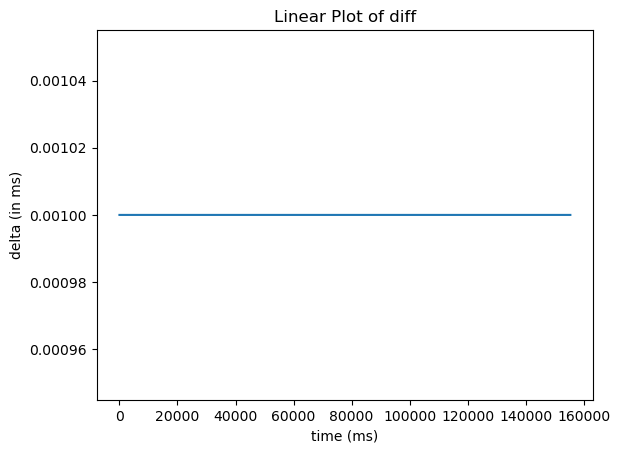

In [7]:
plt.plot(diff)
plt.title('Linear Plot of diff')
plt.xlabel('time (ms)')
plt.ylabel('delta (in ms)')
plt.show()

In [ ]:
sample_rate * seconds

In [8]:
seconds = 2
sample_rate = 1e3
start = 500
windowed_data = data_tensor[:, start:int(start + seconds * sample_rate)]
windowed_data.shape

torch.Size([6, 2000])

In [9]:
windowed_data.max(), windowed_data.min()

(tensor(13.5464, dtype=torch.float64), tensor(-9.7013, dtype=torch.float64))

In [10]:
def normalize_tensor(tensor):
    tensor = torch.from_numpy(tensor)
    min_value = torch.min(tensor)
    max_value = torch.max(tensor)
    normalized_tensor = (tensor - min_value) / (max_value - min_value)
    return normalized_tensor

def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(specgram, origin="lower", aspect="auto", interpolation="nearest")

In [ ]:
SPECGRAM_PARAMS = {
    'window_size': 2,
    'n_fft': 128,
    'hop_length': 4,
    'sampling_rate': 1e3,
    'downsampling_rate': 500,
    'transforms': None,
    'resizes': (64, 192), # patch_size=16 -> (4, 12) = 48 | patch_size=8 -> (8, 24) = 192
}

In [ ]:
prova_2s = torchaudio.functional.resample(windowed_data, 1e3, 500)
# prova_2s = accl_x_interp_torch
# prova_2s = normalize_tensor(prova_2s.numpy())
# 

n_ffts = [128, 256]
hop_length = [2, 4, 8, 16]
amplitude_to_db = T.AmplitudeToDB(stype="power", top_db=90)
specs = []
for i, n_fft in enumerate(n_ffts):
    spectrogram = T.Spectrogram(
        n_fft=n_fft,
        hop_length=4,
        center=True,
        pad_mode="reflect",
        power=2.0,
        normalized=True,
        window_fn=torch.signal.windows.nuttall
    )
    spectrogram.double()

    # 1. spettrogramma
    # 2. da amplitude a dB
    # 3. normalizzare [0,1]
    prova = spectrogram(prova_2s)
    # prova = librosa.power_to_db(prova)
    prova = amplitude_to_db(prova)
    # prova = normalize_tensor(prova.numpy())
    specs.append(prova)
    
for i in range(len(specs)):
    print(specs[i].shape) 

In [ ]:
fig, axs = plt.subplots(1, len(specs), figsize=(20,4))
for i, (spec, n_fft) in enumerate(zip(specs, n_ffts)):
    plot_spectrogram(spec[0], ylabel=f"{n_fft=}", ax=axs[i])
    axs[i].set_xlabel(None)

In [ ]:
windowed_data.shape

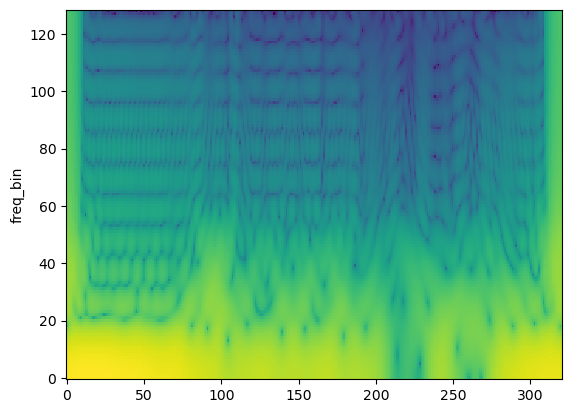

In [18]:
Fs = 50

waveform = windowed_data.type(torch.float32)
waveform = torchaudio.transforms.Resample(sample_rate, Fs)(waveform)
spectrogram_transform = torchaudio.transforms.Spectrogram(
            n_fft=256, 
            win_length=24,
            hop_length=1, 
            window_fn=torch.hann_window ,
        )

resample_ratio = 320/waveform.shape[1]
resample_target = int(100*resample_ratio)
waveform = torchaudio.transforms.Resample(100, resample_target)(waveform)
spectrogram = spectrogram_transform(waveform) # from [1,320] to [1,129,321]
spectrogram_db = torchaudio.transforms.AmplitudeToDB()(spectrogram)
fbank = spectrogram_db[0, :].squeeze(0).transpose(0,1)[:,:128]
plot_spectrogram(spectrogram_db[0], ylabel="freq_bin", ax=None)

In [16]:
fbank.shape

torch.Size([321, 128])

In [ ]:
waveform

In [ ]:
spectrogram_db.shape

# EgoExo4D: Pytorch dataset class

In [ ]:
%cd ..
%cd src

In [ ]:
import os
import json
import pickle as pkl

from data.egoexo4d import EgoExo4D
import torch
from torch.nn import DataParallel
from torch.utils.data import DataLoader

In [ ]:
# Load the json file
# takes = pd.read_json(os.path.join(ego_exo_root, 'takes.json'))
ego_exo_root = os.path.join('/data2', 'EgoExo4D') # Replace with your cli's download directory for Ego-Exo4D
data_dir = os.path.join('/data2', 'EgoExo4D')
takes_path = (os.path.join(os.path.dirname(os.getcwd()), 'data', 'EgoExo4D', 'annotations_pretrain.pkl'))

In [ ]:
SPECGRAM_PARAMS = {
    'window_size': 2,
    'n_fft': 256,
    'win_length': 24,
    'hop_length': 1,
    'sampling_rate': 50,
    'transforms': None,
    'resizes': (128, 320),
    'temporal_points': 160
}

In [ ]:
dataset = EgoExo4D(data_dir, takes_path, ['imu-left', 'imu-right'], **SPECGRAM_PARAMS)

In [ ]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

for _, (imu, omni) in enumerate(dataloader):
    print(imu.shape, omni.shape)
    break